In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import TextDetection
from utils import parse_vintext_label, group_to_lines, get_rotate_crop_image

In [2]:
detector = TextDetection(model_name="PP-OCRv5_mobile_det")

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Dell\.paddlex\official_models\PP-OCRv5_mobile_det`.


In [81]:
# visualize some following images to understand the problem 
# 57, 146: ground truth points are not in right order
# 211, 219, 389: Ground truth is rotated
# 181, 542, 931: Paddle prediction contains mutilple ground truth rows 
# some ground truth text misspell words (e.g. missing accent, not capitalized, etc.)

im_path = "vietnamese_original/train_images/im0002.jpg" # need 4 digits
gt_path = "vietnamese_original/labels/gt_2.txt"

output = detector.predict(im_path)
dt_polys = output[0]['dt_polys']
paddle_lines = dt_polys

word_boxes = parse_vintext_label(gt_path)
line_groups = group_to_lines(word_boxes, 
                             paddle_lines, 
                             min_words_per_line=2,  # only group words if there are at least 2 words in text line
                             min_chars_to_split=26, # enable to get more text lines if text line has more than 26 characters
                             mode='auto')			# enable `auto` to using default PaddleOCR

print([textline['text'] for textline in line_groups])

['TRƯỜNG AN TOÀN']


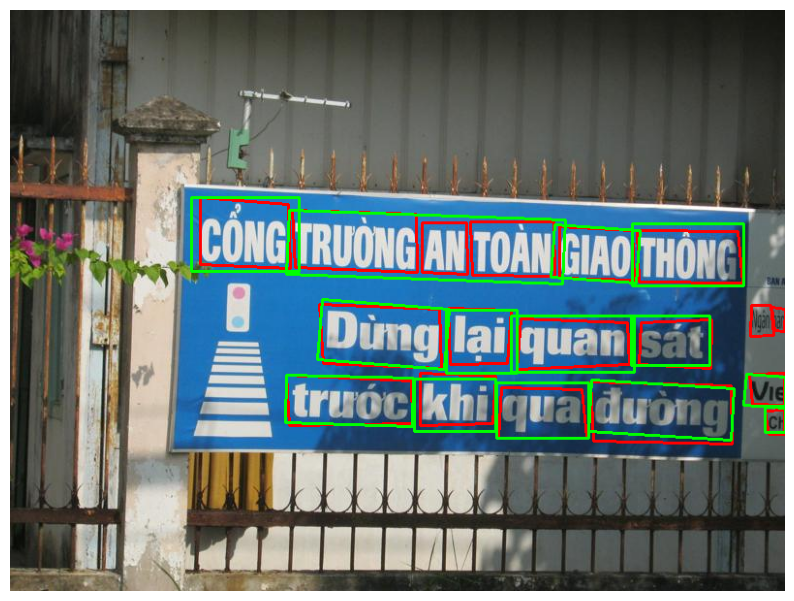

In [82]:
# show intersection between PaddleOCR predictions and grounth truth of VinText words

img = cv2.imread(im_path)

# Draw VinText words (red)
for w in word_boxes:
    pts = np.array(w["bbox"], np.int32)
    cv2.polylines(img, [pts], True, (0, 0, 255), 2)

# Draw PaddleOCR lines (green)
for poly in paddle_lines:
	pts = np.array(poly, np.int32)
	cv2.polylines(img, [pts], True, (0, 255, 0), 2)

	# for idx, (x, y) in enumerate(pts):
		# cv2.circle(img, (int(x), int(y)), 4, (255, 0, 0) if idx == 0 else (0, 255, 0), -1)
		# cv2.putText(img, str(idx), (int(x) + 4, int(y) - 4),
		# 			cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0) if idx == 0 else (0, 255, 0), 1)
    

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

* "TRƯỜNG AN TOÀN" is the only one text line having 3 words; others will be discarded
* Paddle prediction points' order is clockwise, where first point is top left of bbox (but not follows the text orientation, for more detail in the section below - image 166)

In [68]:
def visualize_line_groups(im_path, line_groups, save=False):
	"""
	Visualize or save each line group polygon on an image.

	Args:
		im_path (str): Path to the input image.
		line_groups (list[dict]): List of line groups, each with key "line_box" (list of points).
		save (bool): If True, save each line group as an image in 'final_<image name>/'. 
						If False, just display the combined result.

	"""
	img = cv2.imread(im_path)
	if img is None:
		raise FileNotFoundError(f"Image not found: {im_path}")

	if save:
		base_name = os.path.splitext(os.path.basename(im_path))[0]
		out_dir = f"final_{base_name}"
		os.makedirs(out_dir, exist_ok=True)

		# iterate through each line group
		for idx, line in enumerate(line_groups):
			img_copy = img.copy()

			pts = np.array(line["line_box"], np.int32)
			cv2.polylines(img_copy, [pts], True, (0, 255, 0), 2)

			# mark points (first red, others blue)
			for i, (x, y) in enumerate(line["line_box"]):
				color = (0, 0, 255) if i == 0 else (255, 0, 0)
				cv2.circle(img_copy, (int(x), int(y)), 4, color, -1)
				cv2.putText(img_copy, str(i), (int(x)-10, int(y)-8),
							cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

			rgb = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
			save_path = os.path.join(out_dir, f"crop_{idx:03d}.jpg")
			plt.imsave(save_path, rgb)
    
		print(f"✅ Saved {len(line_groups)} line group images under './{out_dir}'")

	else:
		img_show = img.copy()
		for idx, line in enumerate(line_groups):
			pts = np.array(line["line_box"], np.int32)
			cv2.polylines(img_show, [pts], True, (0, 255, 0), 2)

			# mark points (first red, others blue)
			for i, (x, y) in enumerate(line["line_box"]):
				color = (0, 0, 255) if i == 0 else (255, 0, 0)
				cv2.circle(img_show, (int(x), int(y)), 6, color, -1)
				cv2.putText(img_show, str(i), (int(x)+10, int(y)-10),
							cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 1)
    
		plt.figure(figsize=(10, 10))
		plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
		plt.axis("off")
		plt.show()

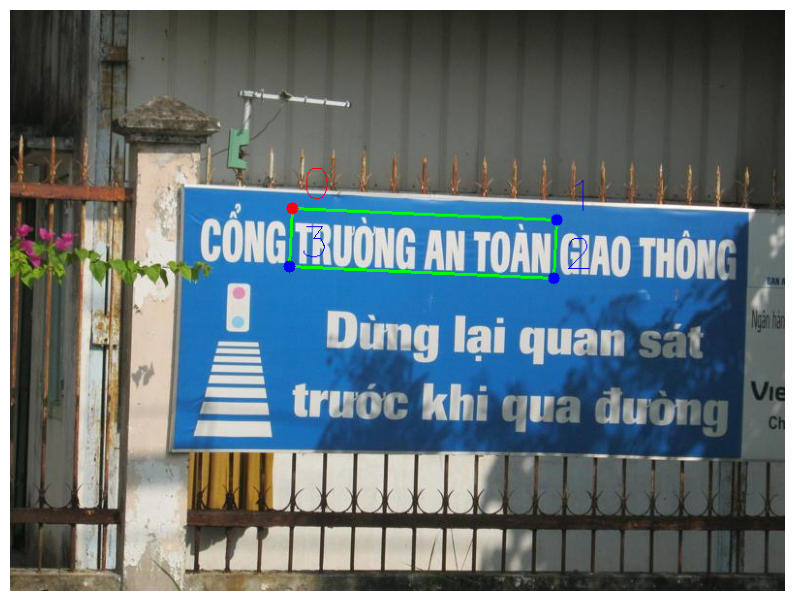

In [69]:
# get final line groups cordinates, point order, and text
visualize_line_groups(im_path, line_groups, save=False)

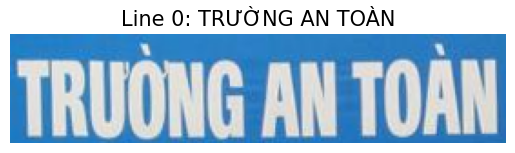

In [70]:
# crop and show each text line

img = cv2.imread(im_path)
 
for i, line in enumerate(line_groups):
	box = np.array(line["line_box"], dtype=np.float32)
	txt = line["text"]
	crop = get_rotate_crop_image(img, box, rotate_90_counter_clockwise=True)
	plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
	plt.axis("off")
	plt.title(f"Line {i}: {txt}", fontsize=15)
	plt.show()

### points order of PaddleOCR polygons

In [71]:
def draw_polygons_ppocr(im_path, save=True):
    output = detector.predict(im_path)
    dt_polys = output[0]['dt_polys']
    paddle_lines = dt_polys

    img = cv2.imread(im_path)
    
    save_dir = "ppocr_" + os.path.basename(im_path).split(".")[0]

    if save and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i, poly in enumerate(paddle_lines):
        pts = np.array(poly, np.int32)
        temp_img = img.copy()

        # Draw polygon outline (green)
        cv2.polylines(temp_img, [pts], True, (0, 255, 0), 2)

        # Draw point index order
        for idx, (x, y) in enumerate(pts):
            cv2.circle(temp_img, (int(x), int(y)), 4, (255, 0, 0), -1)
            cv2.putText(temp_img, str(idx), (int(x) + 4, int(y) - 4),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)

        if save:
            save_path = os.path.join(save_dir, f"poly_{i:03d}.jpg")
            plt.imsave(save_path, cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
        else:
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Polygon #{i}")
            plt.axis("off")
            plt.show()

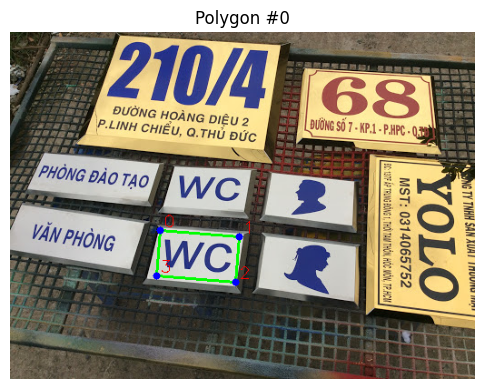

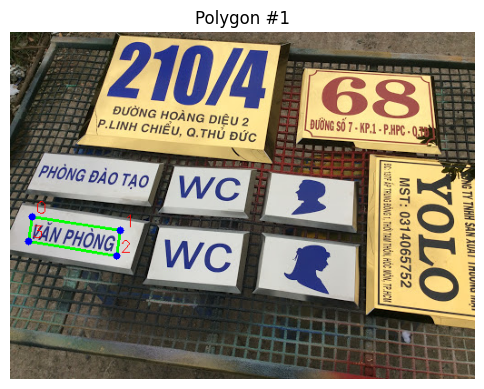

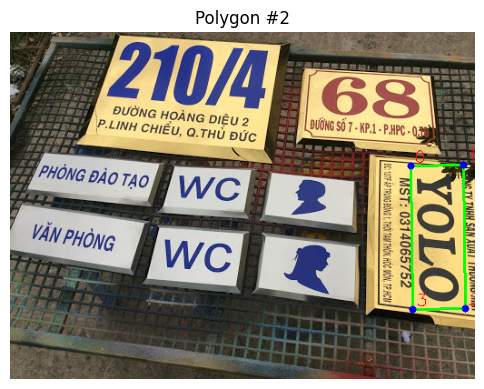

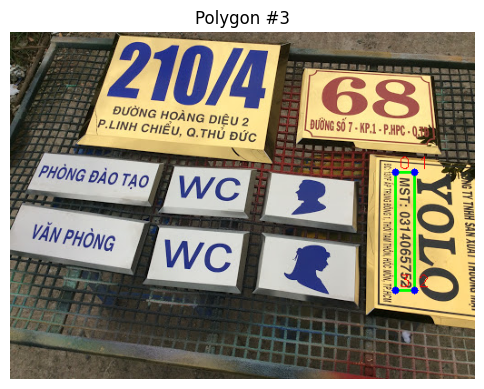

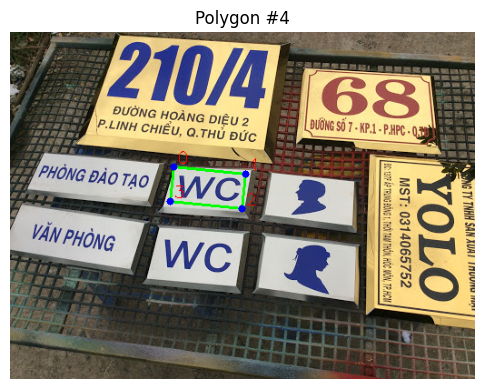

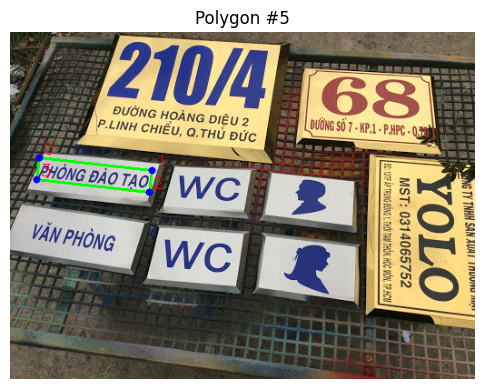

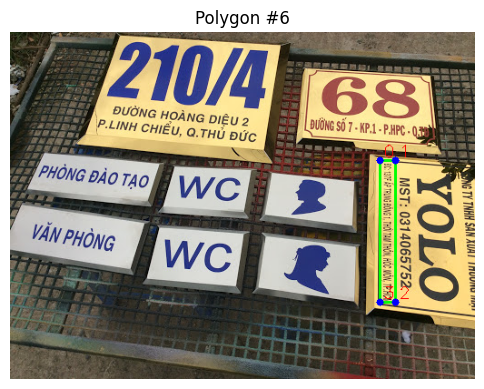

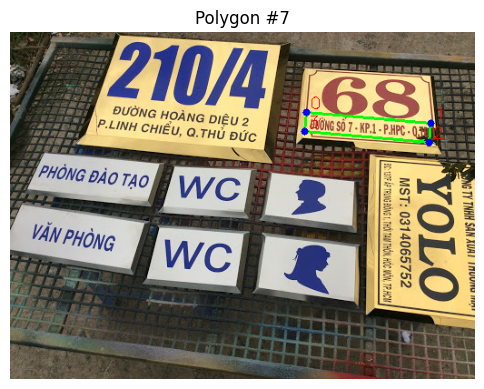

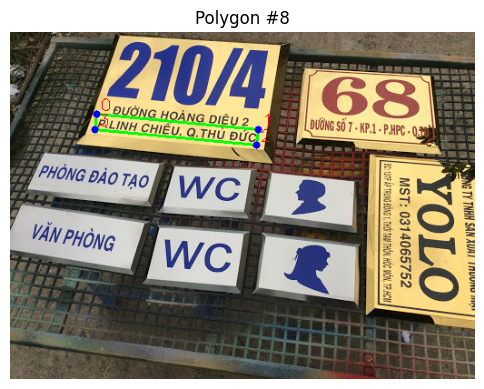

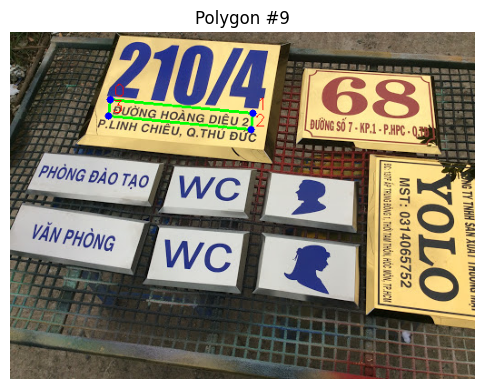

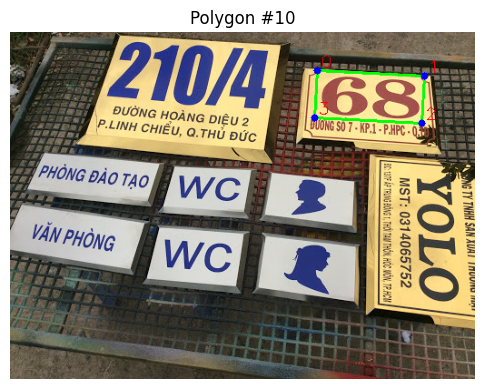

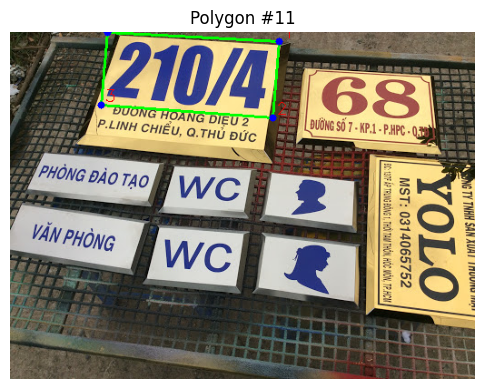

In [72]:
im_path = "vietnamese_original/train_images/im0166.jpg"
draw_polygons_ppocr(im_path, save=False)

### point order of Vintext polygons

In [77]:
def draw_polygons_vintext(im_path, gt_path, save=True):
    img = cv2.imread(im_path)
    word_boxes = parse_vintext_label(gt_path)
    
    # Save directory named after image
    save_dir = "vintext_" + os.path.basename(im_path).split(".")[0]
    if save and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i, w in enumerate(word_boxes):
        pts = np.array(w["bbox"], np.int32)
        temp_img = img.copy()

        # Draw polygon outline (red)
        cv2.polylines(temp_img, [pts], True, (0, 0, 255), 2)

        # Draw point index order
        for idx, (x, y) in enumerate(pts):
            cv2.circle(temp_img, (int(x), int(y)), 4, (255, 0, 0), -1)
            cv2.putText(temp_img, str(idx), (int(x) + 4, int(y) - 4),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)

        if save:
            save_path = os.path.join(save_dir, f"poly_{i:03d}.jpg")
            plt.imsave(save_path, cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
        else:
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Polygon #{i}")
            plt.axis("off")
            plt.show()

In [65]:
im_path = "vietnamese_original/train_images/im0166.jpg"
gt_path = "vietnamese_original/labels/gt_166.txt"
draw_polygons_vintext(im_path, gt_path, save=True)

In [ ]:
# there is a polygon which is not valid

im_path = "vietnamese_original/train_images/im0154.jpg"
gt_path = "vietnamese_original/labels/gt_154.txt"
draw_polygons_vintext(im_path, gt_path, save=False)

In [ ]:
# there is a polygon which is not valid

im_path = "vietnamese_original/train_images/im0057.jpg"
gt_path = "vietnamese_original/labels/gt_57.txt"
draw_polygons_vintext(im_path, gt_path, save=False)